In [2]:
import math

In [3]:
import pandas as pd
import numpy as np
import glob
import ast
from tqdm import tqdm

# =============================
# 1. Load and Combine Parquet Files
# =============================
def load_and_combine_parquet(folder_path: str) -> pd.DataFrame:
    files = glob.glob(folder_path + "/*.parquet")
    dfs = []
    for f in tqdm(files, desc="Reading parquet files"):
        df = pd.read_parquet(f)
        dfs.append(df)
    combined_df = pd.concat(dfs, ignore_index=True)
    return combined_df

# =============================
# 2. Parse List Columns
# =============================
def parse_list(x):
    if isinstance(x, list): 
        return x
    if isinstance(x, str) and x.startswith("["):
        try:
            return ast.literal_eval(x)
        except:
            return []
    return []

# =============================
# 3. Compute SDR per slot
# =============================
def compute_sdr(df: pd.DataFrame):
    records = []

    for _, row in tqdm(df.iterrows(), total=len(df), desc="Processing hexes"):
        h3_index = row["h3_index"]

        for i in range(96):
            start_val = row.get(f"start_{i}", 0)
            end_val = row.get(f"end_{i}", 0)
            idle_val = row.get(f"idle_{i}", [])
            start_end_val = row.get(f"start_end_{i}", (0, 0))

            # Parse start_end
            n, t = (start_end_val if isinstance(start_end_val, tuple) else (0,0))

            # Compute demand
            demand_count = 0
            if isinstance(start_val, (int, float)):
                demand_count += start_val
            demand_count += n  # include intra-hex rides

            # Compute supply
            supply_count = 0
            if isinstance(end_val, (int, float)):
                supply_count += end_val
            if isinstance(idle_val, (list, str)):
                idle_list = parse_list(idle_val)
                supply_count += len(idle_list)

            # Apply smoothing
            demand_adj = demand_count + 0.5
            supply_adj = supply_count + 0.5

            # SDR
            sdr = supply_adj / demand_adj if demand_count > 0 else  0

            records.append({
                "h3_index": h3_index,
                "slot": i,
                "SDR": sdr
            })

    df_out = pd.DataFrame(records)

    # =============================
    # 4. Average SDR across files for same (h3_index, slot)
    # =============================
    df_avg = df_out.groupby(['h3_index', 'slot'], as_index=False).mean(numeric_only=True)

    # =============================
    # 5. Pivot table: slots as columns
    # =============================
    df_pivot = df_avg.pivot(index='h3_index', columns='slot', values='SDR')
    df_pivot.columns = [f"slot_{i}" for i in df_pivot.columns]
    df_pivot = df_pivot.reset_index()

    return df_pivot

# =============================
# 6. Example Run
# =============================
if __name__ == "__main__":
    folder_path = r"C:\Users\moham\Downloads\Namma Yatri\data\Autorickshaw_Availability_Data v3"  # change path
    df = load_and_combine_parquet(folder_path)
    processed_df = compute_sdr(df)

    processed_df.to_parquet("processed_hex_avg_SDR.parquet", index=False)
    print("✅ SDR preprocessing complete. Output saved to processed_hex_avg_SDR.parquet")


Reading parquet files:   0%|          | 0/14 [00:00<?, ?it/s]

Processing hexes: 100%|██████████| 3509/3509 [00:02<00:00, 1622.38it/s]


✅ SDR preprocessing complete. Output saved to processed_hex_avg_SDR.parquet


In [ ]:
df = pd.read_parquet(r"C:\Users\moham\OneDrive\Desktop\Bengaluru Vega\Code\task_2\data\processed_hex_avg_SDR.parquet")

In [5]:
df

,h3_index,slot_0,slot_1,slot_2,slot_3,slot_4,slot_5,slot_6,slot_7,slot_8,...,slot_86,slot_87,slot_88,slot_89,slot_90,slot_91,slot_92,slot_93,slot_94,slot_95
0,609676192047431679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.00000,0.00000,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0
1,609676193926479871,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.00000,0.00000,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0
2,609676194094252031,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.00000,0.00000,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0
3,609676194127806463,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.00000,0.00000,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0
4,609676194161360895,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.02381,0.00000,0.02381,0.071429,0.0,0.0,0.0,0.02381,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,609701820721266687,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.00000,0.00000,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0
252,609701820738043903,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.00000,0.00000,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0
253,609701820754821119,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.00000,0.00000,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0
254,609701820771598335,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.02381,0.02381,0.00000,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0


Plotting SDR for hex: 609676351766527999


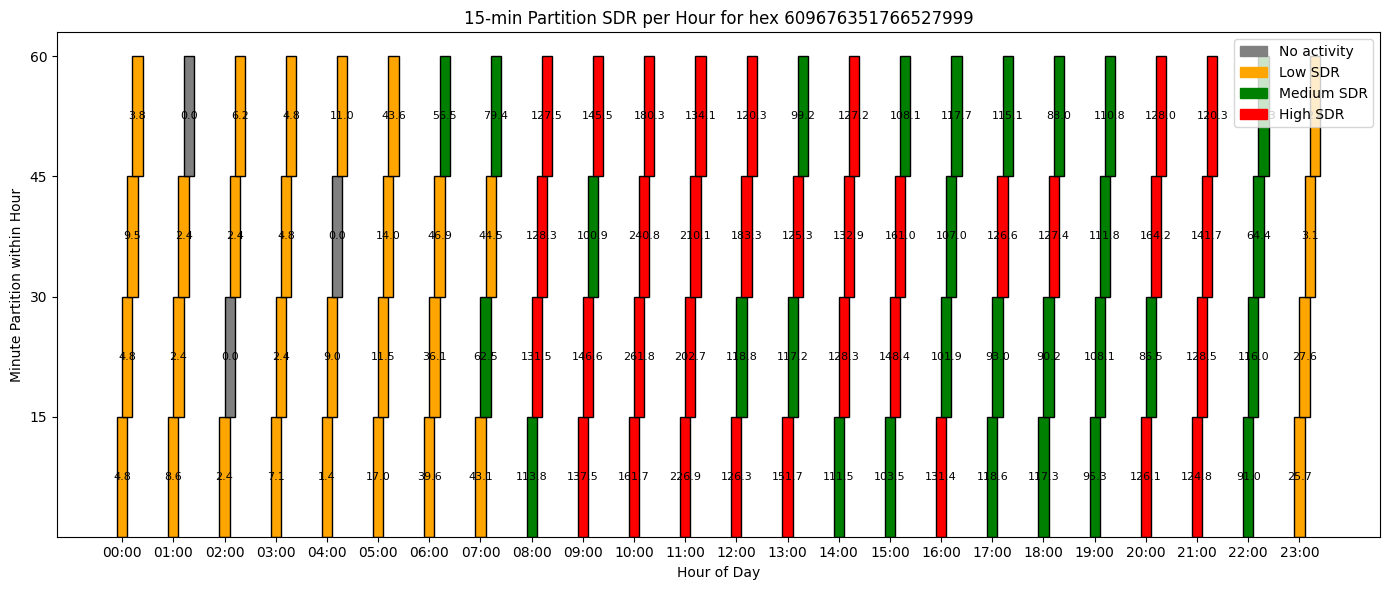

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load averaged SDR data
processed_df = pd.read_parquet("processed_hex_avg_SDR.parquet")

# Select a random hex
random_hex = processed_df['h3_index'].sample(1).values[0]
print(f"Plotting SDR for hex: {random_hex}")

# Extract row for this hex
hex_row = processed_df[processed_df['h3_index'] == random_hex].iloc[0]
slot_sdr = hex_row.drop('h3_index').to_dict()  # slot_0 ... slot_95

# Prepare data: hour, partition, SDR
hours = []
partitions = []
sdr_values = []

for slot_idx, sdr in enumerate(slot_sdr.values()):
    hour = slot_idx // 4
    partition = (slot_idx % 4 + 1) * 15  # 15,30,45,60
    hours.append(hour)
    partitions.append(partition)
    sdr_values.append((sdr if not np.isnan(sdr) else 0) * 100)  # scale by 100

# Define SDR sections and corresponding colors
def sdr_color(sdr):
    if sdr == 0:
        return 'grey'
    elif sdr < 50:
        return 'orange'
    elif sdr < 120:
        return 'green'
    else:
        return 'red'

colors = [sdr_color(val) for val in sdr_values]

# Plot
fig, ax = plt.subplots(figsize=(14,6))

for i in range(len(hours)):
    x_pos = hours[i] + 0.1*(i%4)  # small offset for partitions
    y_bottom = partitions[i] - 15
    height = 15
    ax.bar(x_pos, height, bottom=y_bottom, color=colors[i], edgecolor='black', width=0.2)
    # Annotate SDR value
    ax.text(x_pos, y_bottom + height/2, f"{sdr_values[i]:.1f}", ha='center', va='center', fontsize=8, color='black')

# Formatting
ax.set_xticks(range(24))
ax.set_xticklabels([f"{h:02d}:00" for h in range(24)])
ax.set_yticks([15,30,45,60])
ax.set_ylabel("Minute Partition within Hour")
ax.set_xlabel("Hour of Day")
ax.set_title(f"15-min Partition SDR per Hour for hex {random_hex}")

# Legend
import matplotlib.patches as mpatches
legend_patches = [mpatches.Patch(color=c, label=l) for c,l in [('grey','No activity'),
                                                              ('orange','Low SDR'),
                                                              ('green','Medium SDR'),
                                                              ('red','High SDR')]]
ax.legend(handles=legend_patches, loc='upper right')

plt.tight_layout()
plt.show()


In [ ]:
SDR_FAILURE_THRESHOLD = 0.1

In [17]:
import numpy as np

def pa(SDR_list, area_list, alpha=2.0, beta=0.0):
    """
    SDR_list: list of SDR values for neighboring hexes at a given time slot
    area_list: corresponding area coverage of each hex
    alpha: sensitivity parameter
    beta: baseline parameter
    Returns predicted time in minutes (0-3)
    """
    SDR_list = np.array(SDR_list)
    area_list = np.array(area_list)
    weighted_sdr = np.sum(SDR_list * area_list)
    
    if weighted_sdr < SDR_FAILURE_THRESHOLD:
        return 30.0
    else:
        log_transformed_sdr = math.log(1 + weighted_sdr)
        prob = 1 / (1 + np.exp(-(alpha * log_transformed_sdr + beta)))
        predicted_pa = 9.0 * (1 - prob)
        return predicted_pa

# Example usage
SDRs = [0.013, 0.021, 0.01]      # SDR for neighboring hexes
areas = [5.18, 5.18, 5.12]  # area in sq km (or radius-based weight)
pred_time = pa(SDRs, areas, alpha=2, beta= 0.0)
print(f"Predicted time: {pred_time:.2f} minutes")


Predicted time: 3.59 minutes


In [18]:
PB_ALPHA = 0.2
PB_BETA = 0.3

In [ ]:
def predict_pb_exponential(SDR_list, area_list, alpha=PB_ALPHA, beta=PB_BETA):
    SDR_list = np.array(SDR_list)
    area_list = np.array(area_list)
    y = np.sum(SDR_list * area_list)
    prob = 1 / (1 + np.exp(-(alpha * y + beta)))
    return 7 * (1 - prob)
